In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import time

from tensorflow.python.keras.models import  save_model,load_model
from deepctr.layers import custom_objects

import numpy as np

Import Model
---

In [9]:
header_row = ['label','I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26']

start_load_time = time.time()
data = pd.read_csv('data/kaggle-display-advertising-challenge-dataset/train.txt', sep='\t', names=header_row, nrows=100)
print("Loading Time:",time.time()-start_load_time)

sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I'+str(i) for i in range(1, 14)]

data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0,)
target = ['label']

 # 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
    
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

# 2.count #unique features for each sparse field,and record dense feature field name

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].max() + 1, embedding_dim=4)
                          for i, feat in enumerate(sparse_features)] + [DenseFeat(feat, 1, )
                                                                        for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
    

print("Shape:",data.shape)

pd.set_option('display.max_columns', len(data))
data

Loading Time: 0.17855405807495117
Shape: (100, 40)


,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,0.011364,0.000839,0.007911,0.000000,0.002028,0.001899,0.102041,0.040816,0.138591,0.333333,0.133333,0.00,0.025974,8,24,82,37,1,3,88,2,1,45,67,21,14,1,44,44,8,67,5,3,7,0,1,50,7,17
1,0,0.022727,0.000420,0.069620,0.013333,0.000150,0.003799,0.013605,0.040816,0.003063,0.333333,0.066667,0.00,0.051948,8,46,35,21,1,5,60,0,1,13,24,31,78,7,79,66,0,44,5,1,42,0,1,15,7,13
2,0,0.022727,0.000420,0.001582,0.186667,0.001126,0.042260,0.027211,0.040816,0.187596,0.333333,0.200000,0.25,0.584416,3,3,2,53,1,3,81,0,1,16,30,47,68,0,37,23,6,18,0,0,75,2,1,13,0,0
3,0,0.000000,0.375157,0.000000,0.000000,0.006446,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,8,9,50,13,1,5,24,0,1,62,82,56,18,0,10,32,1,37,0,0,45,0,1,32,0,0
4,0,0.034091,0.000000,0.000000,0.000000,0.000003,0.000000,0.020408,0.000000,0.000000,0.333333,0.066667,0.00,0.000000,11,36,67,71,1,1,73,0,1,24,83,34,85,1,46,1,1,15,0,0,16,0,0,48,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0.000000,0.044482,0.001582,0.013333,0.251721,0.000000,0.000000,0.020408,0.009954,0.000000,0.000000,0.00,0.012987,0,10,11,39,5,3,67,7,0,14,79,39,29,1,26,62,0,65,0,0,40,0,2,54,0,0
96,0,0.000000,0.015107,0.142405,0.026667,0.060509,0.167142,0.000000,0.102041,0.033691,0.000000,0.000000,0.00,0.064935,0,40,24,61,1,3,51,2,1,8,39,26,7,7,31,51,8,53,10,3,31,0,8,14,8,10
97,0,0.000000,0.000420,0.123418,0.013333,0.023239,0.104463,0.006803,0.020408,0.000766,0.000000,0.066667,0.00,0.012987,0,2,55,59,1,5,69,0,1,21,77,40,27,0,23,56,7,27,9,3,58,0,1,2,7,38
98,0,0.000000,0.720101,0.000000,0.013333,0.011073,0.009022,0.102041,0.020408,0.066616,0.000000,0.466667,0.00,0.012987,6,31,40,68,1,3,90,2,1,67,4,22,52,2,24,54,4,31,0,0,30,0,1,28,0,0


In [7]:
data.shape

(3000000, 40)

In [8]:
fixlen_feature_columns

[SparseFeat(name='C1', vocabulary_size=1391, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fb9ae0d8790>, embedding_name='C1', group_name='default_group', trainable=True),
 SparseFeat(name='C2', vocabulary_size=544, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fb9ae0d8890>, embedding_name='C2', group_name='default_group', trainable=True),
 SparseFeat(name='C3', vocabulary_size=863387, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fb9ae0d8850>, embedding_name='C3', group_name='default_group', trainable=True),
 SparseFeat(name='C4', vocabulary_size=274717, embedding_dim=4, use_hash=False, vocabulary_path=None, dty

Generate the training samples and train the model
---

In [5]:
train, test = train_test_split(data, test_size=0.2)

train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy",
              metrics=['binary_crossentropy'], )

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=10, verbose=1, validation_split=0.2, )


Epoch 1/10
7500/7500 [==============================] - 669s 89ms/step - loss: 0.4895 - binary_crossentropy: 0.4810 - val_loss: 0.4781 - val_binary_crossentropy: 0.4618
Epoch 2/10
7500/7500 [==============================] - 659s 88ms/step - loss: 0.4716 - binary_crossentropy: 0.4526 - val_loss: 0.4783 - val_binary_crossentropy: 0.4597
Epoch 3/10
7500/7500 [==============================] - 751s 100ms/step - loss: 0.4669 - binary_crossentropy: 0.4452 - val_loss: 0.4799 - val_binary_crossentropy: 0.4588
Epoch 4/10
7500/7500 [==============================] - 664s 89ms/step - loss: 0.4632 - binary_crossentropy: 0.4382 - val_loss: 0.4835 - val_binary_crossentropy: 0.4596
Epoch 5/10
7500/7500 [==============================] - 817s 109ms/step - loss: 0.4571 - binary_crossentropy: 0.4285 - val_loss: 0.4885 - val_binary_crossentropy: 0.4598
Epoch 6/10
7500/7500 [==============================] - 705s 94ms/step - loss: 0.4156 - binary_crossentropy: 0.3845 - val_loss: 0.5000 - val_binary_cross

In [15]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
C1 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C2 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C3 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C4 (InputLayer)                 [(None, 1)]          0                                            
____________________________________________________________________________________________

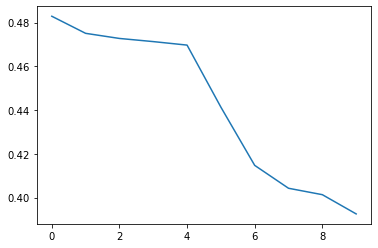

In [7]:
plt.plot(history.history['loss'])

Continued Model Training
---

In [5]:
model = load_model('models/DeepFM-01.h5',custom_objects)# load_model,just add a parameter

In [7]:
train, test = train_test_split(data, test_size=0.2)

train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=10, verbose=1, validation_split=0.2, )

Epoch 1/10
7500/7500 [==============================] - 723s 96ms/step - loss: 0.4423 - binary_crossentropy: 0.4019 - val_loss: 0.4643 - val_binary_crossentropy: 0.4224
Epoch 2/10
7500/7500 [==============================] - 785s 105ms/step - loss: 0.3821 - binary_crossentropy: 0.3471 - val_loss: 0.4898 - val_binary_crossentropy: 0.4552
Epoch 3/10
7500/7500 [==============================] - 720s 96ms/step - loss: 0.3919 - binary_crossentropy: 0.3572 - val_loss: 0.5084 - val_binary_crossentropy: 0.4681
Epoch 4/10
7500/7500 [==============================] - 698s 93ms/step - loss: 0.4017 - binary_crossentropy: 0.3624 - val_loss: 0.5097 - val_binary_crossentropy: 0.4678
Epoch 5/10
5063/7500 [===================>..........] - ETA: 3:43 - loss: 0.3656 - binary_crossentropy: 0.3285

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])

In [8]:
pred_ans = model.predict(test_model_input, batch_size=256)

In [9]:
print("test MSE", round(mean_squared_error(test[target].values, pred_ans), 4))
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

test MSE 0.1528
test LogLoss 0.472
test AUC 0.7762


In [16]:
eval_result = model.evaluate(test_model_input)
print(eval_result)

18750/18750 [==============================] - 387s 21ms/step - loss: 0.0388 - binary_crossentropy: 0.0000e+00
[0.038802243769168854, 0.0]


In [17]:
test.label

686261     0
529098     0
2951407    0
895284     1
2397297    0
          ..
857628     0
527486     0
2197763    1
1835980    0
1315915    0
Name: label, Length: 600000, dtype: int64

In [18]:
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0

for sample_i in range(len(pred_ans)):
    if round(pred_ans[sample_i][0]) == test.label.iloc[sample_i]: # Predicted == Actual
        if test.label.iloc[sample_i] == 1:
            true_pos += 1
        else:
            true_neg += 1
    else:
        if test.label.iloc[sample_i] == 1:
            false_neg += 1
        else:
            false_pos += 1

accuracy = (true_pos + true_neg) / len(pred_ans)
print("Accuracy:",accuracy)

Accuracy: 0.7806666666666666


In [19]:
save_model(model, 'DeepFM.h5')# save_model, same as before

In [ ]:
model = load_model('DeepFM.h5',custom_objects)# load_model,just add a parameter

Brute Force Explainability Tensor
---

In [11]:
print(dense_features)

['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13']


In [40]:
dense_features = ['I1', 'I2', 'I3', 'I4']
rec_space_dim = 10
ndims = len(dense_features)
bfet_shape = (rec_space_dim,) * ndims
bfet = np.ndarray(bfet_shape)
bfet.shape

(10, 10, 10, 10)

In [44]:
bfet[5, 5, 5, 5] = -1

